<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/drugVAE/dataset_selfies_08_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset conversion (SELFIES)

In [ ]:
cd /content

/content


In [ ]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git

rm: cannot remove 'a_inhibitor_design': No such file or directory
Cloning into 'a_inhibitor_design'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 115 (delta 32), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 218.25 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
cd a_inhibitor_design

/content/a_inhibitor_design


In [ ]:
! pip install selfies --quiet

In [ ]:
from data.tokenizer_selfies import SmilesToSelfies
import pandas as pd

data = pd.read_csv('/content/a_inhibitor_design/data/jak_smiles.csv')
print(data.head())

# Converting smiles to selfies
selfies_df = SmilesToSelfies(data.Smiles)
print(selfies_df.head())
print(selfies_df.shape)


                                              Smiles
0  [2H]C([2H])([2H])N=C(O)c1cnc(N=C(O)C2CC2)cc1Nc...
1  [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc...
2  [2H]C([2H])([2H])NC(=O)c1n[nH]c(=NC(=O)C2CC2)c...
3  [2H]C([2H])([2H])NC(=O)c1n[nH]c(=Nc2ccc(F)cn2)...
4  [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc...


100%|██████████| 25739/25739 [00:46<00:00, 554.88it/s]


(                                             Selfies
 0  [2H][C][Branch1][C][2H][Branch1][C][2H][N][=C]...
 1  [2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
 2  [2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
 3  [2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
 4  [2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...,
 (25739, 1))

In [ ]:
from data.tokenizer_selfies import SelfiesToDataset

MAX_LEN = 120
print('define the max len of dataset')
dict_ = SelfiesToDataset(selfies_df, max_len=120, savename='test.pt')

len alphabet:  59
max len in dataset: 109


100%|██████████| 25739/25739 [00:13<00:00, 1894.29it/s]


dataset saved at: test.pt


In [ ]:
dict_.keys()

dict_keys(['labels', 'one_hots', 'alphabet'])

In [ ]:
print('onehot vector shape [len_drug, max_len]: ', dict_['labels'].shape)
print('onehot matrix shape [len_drug, max_len, len_alphabet]: ',
      dict_['one_hots'].shape)
print('selfies alphabet len: ', len(dict_['alphabet']))

onehot vector shape [len_drug, max_len]:  torch.Size([25739, 120])
onehot matrix shape [len_drug, max_len, len_alphabet]:  torch.Size([25739, 120, 59])
selfies alphabet len:  59


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [ ]:
class Classifier_binary(nn.Module):
    """
    simple classifier, for prediction using latent space z
    https://dejanbatanjac.github.io/2019/07/04/softmax-vs-sigmoid.html
    """
    def __init__(self, dims, tasktype, multitask):
        """
        takes latent z as input, compute labels
        :param dims: [in_dim, h_dims, out_dim]
            in_dim: the same as latent z dim
            h_dims: hidden dims, a list of int
            out_dim: the same as task label
        :param tasktype:
            'R': regression task, need MSELoss
            'C': classification task, BCELoss sum
        :param multitask:
            True:
            doing multitask the same time,
            e.g. predicting 4 JAK simutaneously
            label could be
            [1, 1, 0, 1]:  jak1, 2, tyk2 inhibitor
            need sigmoid output instead of softmax

            False: doing single task
                if regression: nn.Linear
                if classification:
                    softmax for label > 2
                    sigmoid for binary
        """
        super(Classifier_binary, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        assert out_dim == 1
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

        # self.multitask = multitask
        # self.tasktype = tasktype

        # if self.tasktype == 'R': print('desired loss function: MSELoss')
        # if self.tasktype == 'C': print('desired loss funciton: BCELoss')



    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
            # print(x.shape) [batch_size, h_dim[-1]]
        x = self.final(x)
        x = torch.sigmoid(x)
        return x

        # if self.tasktype == 'R': return x # need MSELoss

        # if self.tasktype == 'C': # need BCELoss

        #         # task such as identifying JAK inhibitors
        #         # labels are not onehot but could be
        #         # [1, 1, 1, 0]: JAK1, 2, 3 inhibitor
        #     if self.multitask: return F.sigmoid(x)

        #     # onehot label

        #     else: return F.softmax(x, dim=-1)


In [ ]:
aad = torch.tensor([0.6, 0.3]).cuda()


loss_function(aad, aad)

tensor(0.5889, device='cuda:0')

In [ ]:
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git

rm: cannot remove 'JAK_ML': No such file or directory
Cloning into 'JAK_ML'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 299 (delta 83), reused 105 (delta 54), pack-reused 131
Receiving objects: 100% (299/299), 8.39 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
model.loss_function(aad, aad)

tensor(0.4799, device='cuda:0')

In [ ]:
import pandas as pd
data = pd.read_csv('new_data/JAK1_final.csv')
data.head()

,Unnamed: 0,Smiles,Activity
0,0,COCCOC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc...,1
1,1,CC(C)COC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3nc...,1
2,2,C[C@H]1CN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc4[...,1
3,3,C[C@@H]1C[C@@H](CS(=O)(=O)N2CC[C@H](CO)C2)CC[C...,1
4,4,CN(c1ncnc2[nH]ccc12)[C@H]1CC[C@H](CS(=O)(=O)N2...,1


In [ ]:
cd JAK_ML/new_data

/content/JAK_ML/new_data


In [ ]:
from ML_code.function import *
# from function import *

In [ ]:
MACCS_list = smile_list_to_MACCS(data['Smiles'].tolist())
header = ['bit' + str(i) for i in range(167)]
df = pd.DataFrame(MACCS_list, columns = header)
df['Activity'] = data['Activity']

In [ ]:
df

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166,Activity
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
7369,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
7370,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
7371,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

print('train, test shape: ', train.shape, test.shape)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

p = 0
n = 0
for i in train['Activity']:
    if i == 0: n += 1
    elif i == 1: p+=1
print(f"train dataset: inhibitors: {p} noninhibitors: {n}")


p = 0
n = 0
for i in test['Activity']:
    if i == 0: n += 1
    elif i == 1: p+=1
print(f"test dataset:  inhibitors: {p} noninhibitors: {n}")



train, test shape:  (5898, 168) (1475, 168)
train dataset: inhibitors: 4525 noninhibitors: 1373
test dataset:  inhibitors: 1081 noninhibitors: 394


epoch 0: 100%|██████████| 369/369 [00:10<00:00, 35.22it/s]


[Train] loss: 0.333
[Test] loss: 0.373


epoch 1: 100%|██████████| 369/369 [00:09<00:00, 37.92it/s]


[Train] loss: 0.248
[Test] loss: 0.221


epoch 2: 100%|██████████| 369/369 [00:10<00:00, 36.77it/s]


[Train] loss: 0.222
[Test] loss: 0.218


epoch 3: 100%|██████████| 369/369 [00:10<00:00, 35.03it/s]


[Train] loss: 0.194
[Test] loss: 0.262


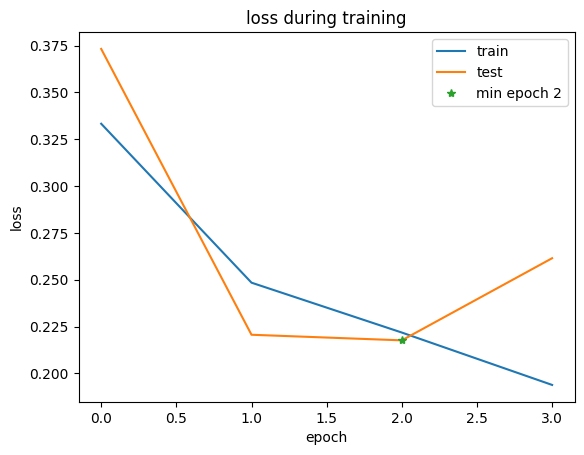

epoch 4: 100%|██████████| 369/369 [00:10<00:00, 35.37it/s]


[Train] loss: 0.182
[Test] loss: 0.196


epoch 5: 100%|██████████| 369/369 [00:14<00:00, 25.99it/s]


[Train] loss: 0.166
[Test] loss: 0.201


epoch 6: 100%|██████████| 369/369 [00:09<00:00, 37.74it/s]


[Train] loss: 0.156
[Test] loss: 0.184


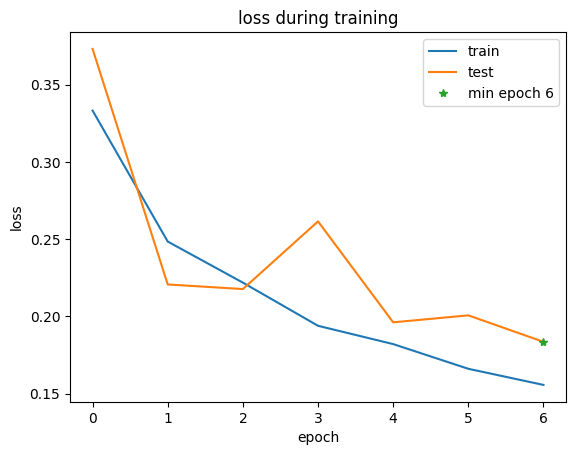

Get current working directory :  /content/JAK_ML
model saved at:  test_6.pt


epoch 7: 100%|██████████| 369/369 [00:09<00:00, 37.17it/s]


[Train] loss: 0.148
[Test] loss: 0.187


epoch 8: 100%|██████████| 369/369 [00:10<00:00, 35.03it/s]


[Train] loss: 0.143
[Test] loss: 0.211


epoch 9: 100%|██████████| 369/369 [00:10<00:00, 34.53it/s]


[Train] loss: 0.143
[Test] loss: 0.184


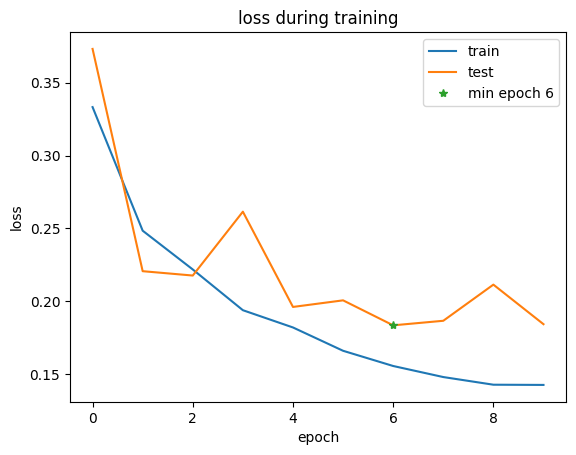

epoch 10: 100%|██████████| 369/369 [00:10<00:00, 34.37it/s]


[Train] loss: 0.135
[Test] loss: 0.187


epoch 11: 100%|██████████| 369/369 [00:10<00:00, 35.06it/s]


[Train] loss: 0.123
[Test] loss: 0.171
Get current working directory :  /content/JAK_ML
model saved at:  test_11.pt


epoch 12: 100%|██████████| 369/369 [00:09<00:00, 36.99it/s]


[Train] loss: 0.125
[Test] loss: 0.185


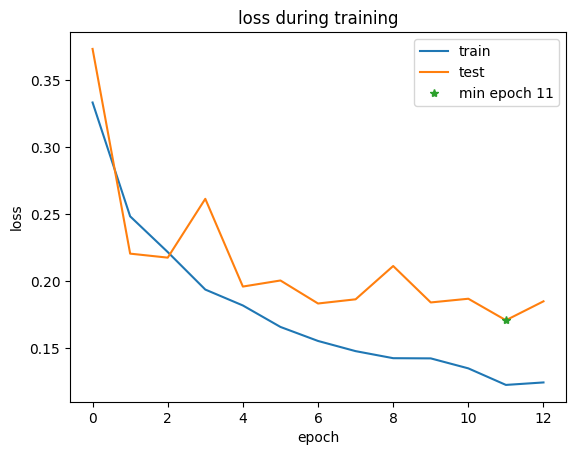

epoch 13: 100%|██████████| 369/369 [00:10<00:00, 36.51it/s]


[Train] loss: 0.125
[Test] loss: 0.172


epoch 14: 100%|██████████| 369/369 [00:10<00:00, 35.96it/s]


[Train] loss: 0.120
[Test] loss: 0.207


epoch 15: 100%|██████████| 369/369 [00:10<00:00, 33.96it/s]


[Train] loss: 0.115
[Test] loss: 0.192


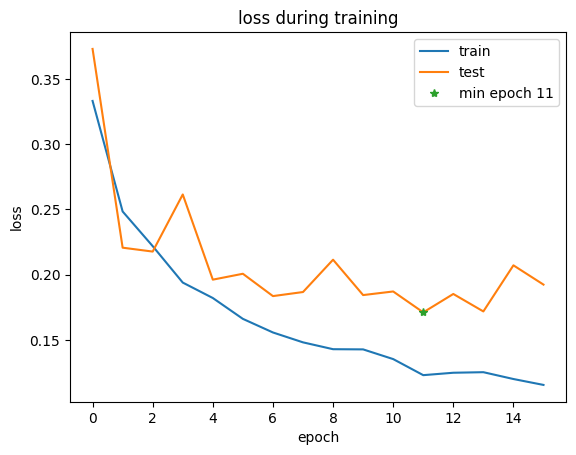

epoch 16: 100%|██████████| 369/369 [00:11<00:00, 32.17it/s]


[Train] loss: 0.116
[Test] loss: 0.207


epoch 17: 100%|██████████| 369/369 [00:10<00:00, 33.58it/s]


[Train] loss: 0.109
[Test] loss: 0.228
early stop, large increase


In [ ]:
class jak_dataset(Dataset):
    def __init__(self, df):
        super(jak_dataset, self).__init__()

        self.len = len(df)
        self.df = df
    def __getitem__(self, idx):
        header = ['bit' + str(i) for i in range(167)]
        fp = self.df[header]
        fp = torch.tensor([float(b) for b in fp.iloc[idx]])
        label = self.df['Activity'][idx]
        # print(label)
        # label = onehot(2)(label)
        label = torch.tensor([label])
        return fp, label
    def __len__(self):
        return self.len

train_dataset = jak_dataset(train)

test_dataset = jak_dataset(test)

params = {'batch_size': 16, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

in_dim = 167
hid_dims = [256, 64]
out_dim = 1


class Classifier_binary(nn.Module):
    """
    simple classifier, for prediction using latent space z
    https://dejanbatanjac.github.io/2019/07/04/softmax-vs-sigmoid.html
    """
    def __init__(self, dims):
        super(Classifier_binary, self).__init__()
        [in_dim, h_dims] = dims
        # assert out_dim == 1
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], 1)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
            # print(x.shape) [batch_size, h_dim[-1]]
        x = self.final(x)
        x = torch.sigmoid(x)
        return x

model = Classifier_binary([in_dim, hid_dims])

cuda = torch.cuda.is_available()

if cuda:
    model = model.cuda()
import os

optimizer = optim.AdamW(params=model.parameters(), lr=1e-2, weight_decay=1e-2)
epochs = 30
train_loss_dict = {}
test_loss_dict = {}
loss_function = nn.BCELoss()
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader),
                               total=len(train_loader), desc=f'epoch {epoch}'):

        optimizer.zero_grad()

        if cuda:
            fp, label = fp.float().cuda(), label.cuda()
        # print(fp.shape) torch.Size([16, 167])

        output = model(fp)
        if output.dtype != label.dtype:
            label = label.type(output.dtype)
        loss = loss_function(output, label)
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader)
    print(f'[Train] loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_test_loss = 0
    for i, (fp, label) in enumerate(test_loader):

        if torch.cuda.is_available():
            fp, label = fp.float().cuda(), label.cuda()

        output = model(fp)
        label = label.type(output.dtype)

        loss = loss_function(output, label)
        # print(output, label)

        # print('test:', loss)
        total_test_loss += loss.item()

    total_test_loss /= len(test_loader)

    print(f'[Test] loss: {total_test_loss:.3f}')
    test_loss_dict[epoch] = total_test_loss

    if epoch % 3 == 0 and epoch != 0:
        plot_loss(train_loss_dict, test_loss_dict)

    argmin, min_loss = get_min(test_loss_dict)
    if test_loss_dict[epoch] <= min_loss and epoch > 5:
        torch.save(model.state_dict(), f'test_{str(epoch)}.pt')
        print('Get current working directory : ', os.getcwd())
        print('model saved at: ', f'test_{str(epoch)}.pt')
    else:
        if epoch - argmin > 10:
            print('early stop, no decrease')
            break
        if test_loss_dict[epoch] / min_loss > 1.3:
            print('early stop, large loss increase')
            break


In [ ]:
def early_stop(current_epoch, test_dict, epoch_interval=10):
    continue_run = True
    argmin_epoch, min_loss = get_min(test_dict)
    if test_dict[current_epoch] - argmin_epoch > epoch_interval:
        print('early stop, loss no decrease after 10 epoch')
        return continue_run
    if test_dict[epoch] / min_loss > 1.1:
        print('early stop, loss increase')
        return continue_run

In [ ]:
ls

chemberta/  new_data/         streamlit-hello-2022-08-13-03-08-23.gif
cnn/        README.md         VAE/
ML_code/    requirements.txt


In [ ]:
dict_ = {1: 20, 2: 30, 0: 23, 9:1, 7: 10}

KeyError: ignored

In [ ]:
import os
from tqdm import tqdm
import math
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# from chembertforclassification import chembertforclassification
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score
# from const import *

In [ ]:
test

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166,Activity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1
1473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0


In [ ]:
# dataset = jak_dataset(df)
test_dataset[1474]


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
         0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1.]),
 tensor([0]))

0

In [ ]:
len(train_loader), len(test_loader)

(369, 93)

In [ ]:
x = x.type(torch.cuda.FloatTensor)

In [ ]:
output.dtype, label.dtype


label = label.type(output.dtype)

In [ ]:
F.binary_cross_entropy(output, label, reduction='sum')

RuntimeError: ignored

In [ ]:
def onehot(k):
    """
    Converts a number to its torch.Size([k])
    one-hot representation vector
    :param k: (int) length of vector
    : return onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k: y[label] = 1
        return y
    return encode # torch.Size([k])

onehot(2)(1)

tensor([0., 1.])

epoch 0:   0%|          | 0/369 [00:00<?, ?it/s]

torch.Size([16, 167])


AttributeError: ignored

In [ ]:
fps = df[header][:16]
fps = fps.astype(float)
data_tensor = torch.tensor(fps.values)
print(data_tensor.shape)
out = model(data_tensor.cuda())

torch.Size([16, 167])


RuntimeError: ignored

In [ ]:
output

In [ ]:
torch.softmax(a, 1)[:, 1]

IndexError: ignored

In [ ]:
# torch.Tensor(df[header])


df[header] = df[header].astype(float)
te = torch.Tensor(df[header].values)
model(te)

In [ ]:
total_test_loss = 0
y_preds = []
y_trues = []
y_probs = []
for i, (fp, label) in enumerate(test_loader):
    if torch.cuda.is_available():
        print('fp shape:', fp.shape, label.shape)
        fp, label = fp.float().cuda(), label.cuda()

    output = model(fp)
    label = label.type(output.dtype)

    loss = model.loss_function(output, label)
    print(output, label)
    print('test:', loss)
    total_test_loss += loss.item()

total_test_loss /= len(test_loader)

print(f'[Test] loss: {total_test_loss}')
test_loss_dict[epoch] = total_test_loss

In [ ]:
_, b = torch.max(output, 1)
output

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
b
a = np.array([1, 0, 1, 1])

evaluate(a, a, a)

Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 1.000  &  1.000  &          1.000  &     1.000  &1.000  &1.000 &1.000 &   1.000 &   1.000


In [ ]:

# for i in model(te.cuda()):
#     if int(i) == 1:
#         pass
#     else:
#         print('0')

n = 0
p = 0
for i in df['Activity']:
    # print(i)
    if i == 0: n +=1
    else: p+=1
print(p, n)




5606 1767


In [ ]:
import matplotlib.pyplot as plt

def get_min(d:dict):

    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key is greater than the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label='test')
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()


In [ ]:
a = torch.tensor([1.0, 0.0])
b =  torch.tensor([0.0, 1.0])

a = a.view(2, 1)
b = b.view(2, 1)
F.binary_cross_entropy(a, b)


a = torch.cat([a, a])
d = torch.cat([b, b])
print(a)

F.binary_cross_entropy(a, d)



tensor([[1.],
        [0.],
        [1.],
        [0.]])


tensor(100.)

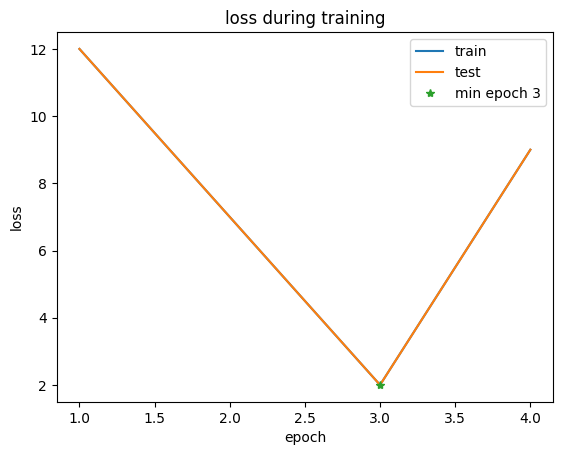

In [ ]:
get_min({1: 12, 3:2, 4: 9})

a = {1: 12, 3:2, 4: 9}
b = {1: 12, 3:2, 4: 9}

plot_loss(a, b)

In [ ]:
x = torch.randn([10, 3, 4])
s0, s1, s2 = x.shape

In [ ]:
h_dim = 3
label_dim = 6
l1 = nn.Linear(s1, h_dim)
l2 = nn.Linear(h_dim, label_dim)

In [ ]:
x = torch.randn([250, 3]) # 3 is z_dim

a1 = l1(x)
a1

In [ ]:
x.shape

torch.Size([10, 3, 4])

In [ ]:
x[1].shape

torch.Size([3, 4])

In [ ]:
# ! pip install rdkit --quiet
# ! pip install molvs --quiet

from rdkit import Chem
from molvs.normalize import Normalizer, Normalization
from rdkit.Chem.SaltRemover import SaltRemover
from molvs.charge import Reionizer, Uncharger
def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

smi = 'C/C=C/C(O)=Nc1cccc(CNc2c(C(=N)O)cnn3cccc23)c1'
new_smiles = preprocess(smi)
print(new_smiles)

C/C=C/C(O)=Nc1cccc(CNc2c(C(=N)O)cnn3cccc23)c1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32374 sha256=9710b2e797f685de344f23840d9e84aed29ce0ffd671466502e2d8e708970d70
  Stored in directory: /root/.cache/pip/wheels/24/a1/39/f02f8173c8ed91bdd386a6c608bb6bf8bd0aba7119315d6f6f
Successfully built molvs


In [ ]:
F.softmax(a1)

<ipython-input-38-514b165b6fdb>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(a1)


tensor([[0.1933, 0.4353, 0.3714],
        [0.1466, 0.4100, 0.4433],
        [0.1698, 0.3171, 0.5131],
        [0.1802, 0.3147, 0.5051],
        [0.1870, 0.2619, 0.5511],
        [0.1813, 0.3748, 0.4439],
        [0.1665, 0.2661, 0.5674],
        [0.1804, 0.4231, 0.3966],
        [0.1777, 0.5052, 0.3171],
        [0.2113, 0.2935, 0.4952],
        [0.1584, 0.4318, 0.4098],
        [0.1714, 0.5542, 0.2744],
        [0.1801, 0.4662, 0.3537],
        [0.1589, 0.1831, 0.6580],
        [0.1525, 0.5751, 0.2725],
        [0.1763, 0.3015, 0.5222],
        [0.1922, 0.4178, 0.3900],
        [0.1933, 0.3507, 0.4559],
        [0.1801, 0.2685, 0.5514],
        [0.1699, 0.3749, 0.4552],
        [0.1734, 0.4847, 0.3418],
        [0.1699, 0.3350, 0.4951],
        [0.1484, 0.5883, 0.2633],
        [0.1610, 0.4011, 0.4379],
        [0.1798, 0.2763, 0.5439],
        [0.1512, 0.4941, 0.3547],
        [0.1763, 0.3372, 0.4865],
        [0.1748, 0.4773, 0.3479],
        [0.1658, 0.3065, 0.5277],
        [0.191

In [ ]:
a1.shape

torch.Size([250, 12])

In [ ]:
F.softmax(a1, dim=-1)

tensor([[0.1933, 0.4353, 0.3714],
        [0.1466, 0.4100, 0.4433],
        [0.1698, 0.3171, 0.5131],
        [0.1802, 0.3147, 0.5051],
        [0.1870, 0.2619, 0.5511],
        [0.1813, 0.3748, 0.4439],
        [0.1665, 0.2661, 0.5674],
        [0.1804, 0.4231, 0.3966],
        [0.1777, 0.5052, 0.3171],
        [0.2113, 0.2935, 0.4952],
        [0.1584, 0.4318, 0.4098],
        [0.1714, 0.5542, 0.2744],
        [0.1801, 0.4662, 0.3537],
        [0.1589, 0.1831, 0.6580],
        [0.1525, 0.5751, 0.2725],
        [0.1763, 0.3015, 0.5222],
        [0.1922, 0.4178, 0.3900],
        [0.1933, 0.3507, 0.4559],
        [0.1801, 0.2685, 0.5514],
        [0.1699, 0.3749, 0.4552],
        [0.1734, 0.4847, 0.3418],
        [0.1699, 0.3350, 0.4951],
        [0.1484, 0.5883, 0.2633],
        [0.1610, 0.4011, 0.4379],
        [0.1798, 0.2763, 0.5439],
        [0.1512, 0.4941, 0.3547],
        [0.1763, 0.3372, 0.4865],
        [0.1748, 0.4773, 0.3479],
        [0.1658, 0.3065, 0.5277],
        [0.191

In [ ]:
F.sigmoid(a1).shape

torch.Size([250, 12])

In [ ]:
F.sigmoid(a1)

tensor([[0.4126, 0.6127, 0.5744],
        [0.3134, 0.5607, 0.5799],
        [0.3029, 0.4479, 0.5676],
        [0.3257, 0.4576, 0.5752],
        [0.3055, 0.3812, 0.5646],
        [0.3546, 0.5319, 0.5737],
        [0.2760, 0.3786, 0.5651],
        [0.3813, 0.5912, 0.5754],
        [0.4301, 0.6821, 0.5739],
        [0.3530, 0.4312, 0.5612],
        [0.3409, 0.5850, 0.5723],
        [0.4650, 0.7376, 0.5819],
        [0.4048, 0.6378, 0.5719],
        [0.2384, 0.2651, 0.5645],
        [0.4366, 0.7451, 0.5807],
        [0.3119, 0.4367, 0.5731],
        [0.3932, 0.5848, 0.5680],
        [0.3617, 0.5069, 0.5719],
        [0.3064, 0.3970, 0.5749],
        [0.3276, 0.5180, 0.5661],
        [0.4092, 0.6594, 0.5773],
        [0.3183, 0.4793, 0.5763],
        [0.4423, 0.7587, 0.5845],
        [0.3306, 0.5516, 0.5732],
        [0.2993, 0.3962, 0.5636],
        [0.3711, 0.6585, 0.5806],
        [0.3162, 0.4693, 0.5607],
        [0.4037, 0.6490, 0.5740],
        [0.2984, 0.4402, 0.5752],
        [0.327